In [2]:
import numpy as np
from scipy.io import loadmat
import pysindy as ps
import matplotlib.pyplot as plt

from pysindy.differentiation import SpectralDerivative

In [3]:
wave1=np.loadtxt('wave1.txt')
wave2=np.loadtxt('wave2.txt')[::64]
wave3=np.loadtxt('wave3.txt')[::4]
wave4=np.loadtxt('wave4.txt')

c1= 1.2065000000000001e-01
c2= 1.4965637499999945e-01
c3= 1.3982499999999973e-01
c4= 1.2780000000000002e-01

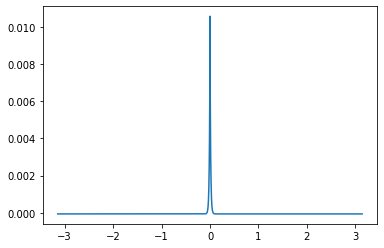

In [4]:
plt.plot(wave2[:,0],wave2[:,2])

In [33]:
def get_diffs(wave,c):
    R=wave[:,0]
    x=wave[:,1]
    Y=wave[:,2]

    sd1=SpectralDerivative(d=1)
    sd2=SpectralDerivative(d=2)
    sd3=SpectralDerivative(d=3)

    Yd1=sd1(Y,R)
    Yd2=sd2(Y,R)
    Yd3=sd3(Y,R)

    Ut=-c*Yd1
    Ux=Yd1
    Uxx=Yd2
    Uxxx=Yd3
    U=Y

    Uxdiffs=np.vstack([U,Ux,Uxx,Uxxx]).T
    return Ut,Uxdiffs

Ut,Xdiffs=get_diffs(wave2,c2)

def get_equation(
        Ut,
        Uxdiffs,
        optimizer,
        degree=2,
        num_digits=4
        ):
    feature_library=ps.PolynomialLibrary(degree=degree)
    poly=feature_library.fit_transform(
        Uxdiffs
    )
    names=feature_library.get_feature_names(['(U)','(Ux)','(Uxx)','(Uxxx)'])

    fitted=optimizer.fit(
        poly,Ut
    )

    eqn="Ut = "
    extra=""

    for coef,term in zip(np.around(fitted.coef_,num_digits)[0],names):
        if term =='1':
            extra+=f"{coef}"
        if coef!=0:
            if coef>0:
                extra+=f" + {coef} * {term}"
            else:
                extra+=f" - {-1*coef} * {term}"
    eqn=eqn+extra

    r2=1-np.mean((Ut-poly@(fitted.coef_[0]))**2)/np.var(Ut)
    print(r2)
    return eqn


In [34]:
waves=[wave1,wave2,wave3,wave4]
c_vals=[c1,c2,c3,c4]

processed=[
    get_diffs(wave,c) for wave,c in zip(waves,c_vals)
]
Ut_vals=[p[0] for p in processed]
Xdiff_vals=[p[1] for p in processed]

In [35]:
Ut_total=np.hstack(Ut_vals)

Xdiffs_total = np.vstack(Xdiff_vals)

In [49]:
optimizer=ps.SR3(threshold=1e-3,nu=1)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer))

optimizer=ps.SR3(threshold=1e-4,nu=1)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer,num_digits=10))

0.9981695745701795
Ut = -0.0 - 0.1434 * (Ux)
0.8896348008868367
Ut = -0.0 - 0.1433641175 * (Ux) - 0.0011282381 * (U) (Ux) - 0.0001711525 * (Ux) (Uxx)


In [31]:
optimizer=ps.SR3(threshold=0,nu=1)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer))

0.9993862927197226
Ut = -0.0 - 0.1434 * (Ux) - 0.0011 * (U) (Ux) - 0.0002 * (Ux) (Uxx)


In [52]:
optimizer=ps.STLSQ(threshold=1e-10)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer,num_digits=16))

0.9993036543541951
Ut = 0.0 + 1.2302372e-09 * (U) - 0.1410135508099212 * (Ux) + 6.4549176e-09 * (Uxxx) - 0.0009479921375157 * (U) (Ux) - 1.492547e-10 * (U) (Uxx) - 1.5362686499e-06 * (U) (Uxxx) - 1.4732891e-09 * (Ux)^2 - 0.0002362799577428 * (Ux) (Uxx) - 2.036862e-10 * (Uxx) (Uxxx)


In [55]:
optimizer=ps.STLSQ(threshold=1e-4)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer,num_digits=16))

0.9989617905782701
Ut = 0.0 - 0.1467858779682037 * (Ux) - 0.0021322981552127 * (U) (Ux)


In [32]:
optimizer=ps.FROLS(
    max_iter=1,
    alpha=0
)

print(get_equation(Ut_total,Xdiffs_total,optimizer=optimizer))

0.9989897062649827
Ut = 0.0 - 0.1476 * (Ux)


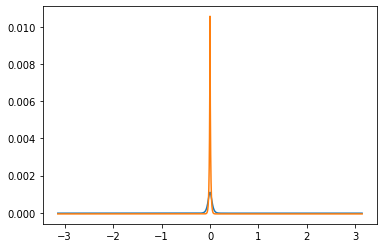

In [10]:
plt.plot(wave1[:,0],wave1[:,2])
plt.plot(wave2[:,0],wave2[:,2])

In [11]:
custom_features=np.vstack([
    Xdiffs_total[:,0]*Xdiffs_total[:,1],
    Xdiffs_total[:,3],
]).T

optimizer=ps.STLSQ(threshold=0.0,alpha=0)

fitted=optimizer.fit(custom_features,Ut_total)

C=fitted.coef_[0]

1-np.mean((custom_features@C-Ut_total)**2)/np.var(Ut_total)

0.8781699349343971

In [342]:
16384/4

4096.0

In [329]:
C

array([[-5.32144362e-17,  9.49794925e-04]])